In [47]:
import heapq 
from collections import Counter

# Final Project Huffman Compression Code
### Regular huffman encoding/decoding


In [ ]:
#################################################################################
#IO Helper functions
#################################################################################
# Reads in a file and returns the text as a string
def readfile(pathname):
    with open(pathname, "r") as f:
        text = f.read()
    return text

# Counts the frequency of each character in a file and returns a dictionary
# Planning on sending in War and Peace txt, which is a large sample of the English language
def count_frequencies(pathname):
    freq = {}
    with open(pathname, "r") as f:
        for char in f.read():
            freq[char] = freq.get(char, 0) + 1
    return freq

# Class for a binary tree node. Holds a character, frequency of that character, and two children
class BTNode:
    def __init__(self, char=None, freq=0):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None
    # "Magic" function that allows you to use it in a priority queue
    # We are using a min queue so want to pull out lowest frequency first
    def __lt__(self, other):
        return self.freq < other.freq

# Builds the regular huffman tree from a dictionary (freqs) 
# Returns the tree and freqs for easy access
def build_huffman_tree(freqs):
    # Make a priority queue which is heapified by minimum frequency 
    priority_queue = [BTNode(ch, f) for ch, f in freqs.items()]
    heapq.heapify(priority_queue)

    # loop while it is length greater than 1, pulling out two elements and then merging them
    while(len(priority_queue) > 1):
        t1 = heapq.heappop(priority_queue)
        t2 = heapq.heappop(priority_queue)
        tree = BTNode(None, t1.freq + t2.freq) # make new tree with t1 on left, t2 on right
        tree.left = t1
        tree.right = t2
        heapq.heappush(priority_queue, tree) # add the tree back onto the priority queue and loop
    huff_tree = priority_queue[0] # return the the one remaining node, the priority tree
    return huff_tree

# recursively builds the codebook, which maps characters to their codes 
def build_codebook(node, prefix = "", codebook = None):
    if codebook is None: 
        codebook = {}
    if node.char is not None: # Base case: if we are at a leaf, add the 
        codebook[node.char] = prefix
    else:
        build_codebook(node.left, prefix + "0", codebook)
        build_codebook(node.right, prefix + "1", codebook)
    return codebook

# encodes a message given a particular codebook
def encode_message(message, codes):
    encoded_message = "".join(codes[ch] for ch in message) # uses generator expression to create encoded message
    return encoded_message

# decodes a message. Note, requires the huff_tree for decoding
def decode_message(encoded_message, huff_tree):
    result = [] # holds decoded message
    node = huff_tree
    for bit in encoded_message:
        node = node.left if bit == "0" else node.right # go left if 0, go right if 1
        if node.char is not None:  # once you get to leaf
            result.append(node.char)  # add the correct character to the decoded message
            node = huff_tree # start back at the top for next iteration
    decoded_message = "".join(result)
    return decoded_message


# Test regular Huffman tree

freqs = count_frequencies("WarAndPeace.txt") # get frequencies from file

test_text = "hello" 
basic_tree = build_huffman_tree(freqs) # build the huffman tree
basic_codes = build_codebook(basic_tree) # build the codebook
encoded = encode_message(test_text, basic_codes) # encode the test text
decoded = decode_message(encoded, basic_tree) # decode the encoded text
print("Basic Codes:", basic_codes)
print("Message:", test_text)
print("Encoded:", encoded)
print("Decoded:", decoded)
assert decoded == test_text # make sure it works

Basic Codes: {'e': '000', 's': '0010', 'h': '0011', 'i': '0100', 'p': '010100', ',': '010101', ':': '01011000000', '6': '010110000010000', '3': '010110000010001', '/': '0101100000100100', '=': '0101100000100101000', ']': '01011000001001010010', '#': '01011000001001010011', '[': '01011000001001010100', '%': '01011000001001010101', '$': '01011000001001010110', '@': '01011000001001010111', '4': '01011000001001011', '9': '0101100000100110', 'Q': '0101100000100111', 'U': '0101100000101', '*': '0101100000110', 'J': '0101100000111', 'j': '0101100001', 'z': '0101100010', 'q': '0101100011', ';': '01011001000', 'K': '01011001001', 'Y': '01011001010', 'G': '01011001011', 'R': '0101100110', '2': '01011001110000', '0': '01011001110001', 'X': '0101100111001', ')': '010110011101', '(': '010110011110', 'L': '010110011111', 'W': '0101101000', 'S': '0101101001', '-': '010110101', 'P': '010110110', 'A': '010110111', 'y': '010111', 'n': '0110', 'o': '0111', 'l': '10000', 'g': '100010', 'v': '1000110', '?'

### Test how many bigrams are needed to converge asymptotically using the WarAndPeace text


Computed K=1000, bits/char=4.0207


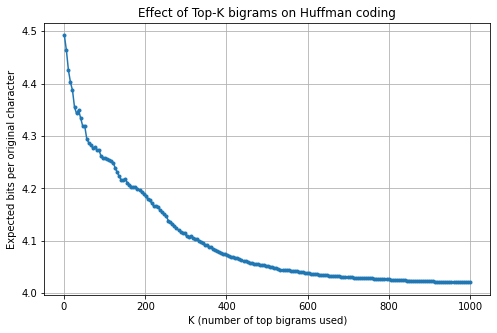

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# Computes the expected bits per character

def expected_bits(freqs, codebook):
    total = sum(freqs.values()) # total number of characters
    bits_per_symbol = sum((freqs[s]/total) * len(codebook[s]) for s in freqs) # bits per symbol = sum of prob(s) * length(code(s))
    avg_chars = sum((freqs[s]/total) * (2 if len(s)==2 else 1) for s in freqs) # average originial characters per symbol is key becaus you have more total symbols with bigrams
    return bits_per_symbol / avg_chars # division gives bits per original character


# Identifies the top K bigrams from the text in terms of freqeuncy
def top_bigrams(text, K):
    counts = Counter(text[i:i+2] for i in range(len(text)-1)) # uses Counter package to count occurences of bigrams in text
    return list(bg for bg,_ in counts.most_common(K)) # returns the K most common bigrams as a list


# Plots the expected bits per original character as a function of K, the number of top bigrams used
# Uses the text to compute frequencies with the top K bigrams included
def experiment_plot(text, K_values, sample_every=1):
    """
    text: input string
    K_values: iterable of K values (increasing ints) to evaluate
    sample_every: only evaluate every sample_every-th K to speed up (optional)
    """
    Ks = []
    bits = []

    # precompute a big list of top bigrams up to max K needed
    K_max = max(K_values)
    bigram_list = top_bigrams(text, K_max)

    current_set = set()
    # We'll add bigrams incrementally so we don't rebuild sets from scratch each iteration
    for i, bg in enumerate(bigram_list, start=1):
        current_set.add(bg)
        if i not in K_values:
            continue
        # compute freqs with current bigrams
        freqs = freqs_with_bigrams(text, current_set)
        # build Huffman and codebook (use your implementations)
        tree = build_huffman_tree(freqs)
        codebook = build_codebook(tree)
        # compute expected bits per original character
        bpc = expected_bits(freqs, codebook)
        Ks.append(i)
        bits.append(bpc)

    plt.figure(figsize=(8,5))
    plt.plot(Ks, bits, marker='.')
    plt.xlabel("K (number of top bigrams used)")
    plt.ylabel("Expected bits per original character")
    plt.title("Effect of Top-K bigrams on Huffman coding")
    plt.grid(True)
    plt.show()

text = readfile("WarAndPeace.txt")
# K_values = list(range(1, 1001))   # evaluate every K from 1..1000
# experiment_plot(text, K_values)

K_values = sorted(set([1] + list(np.linspace(1, 1000, 200, dtype=int))))
experiment_plot(text, K_values)

From this, we concluded that we need around 800-1000 bigrams in our huffman tree to achieve the full benefit to the expected bits per original character. 

# Compare the number of bits used to send the test_message when using the bigram tree compared to the Huffman tree

In [ ]:

# walks through the text and returns a list of symbols ready for Huffman counting to make into a tree
# importnt note: overlapping bigrams are always given priority on the left (ex: for the, th is picked over he)
def replace_bigrams(text, bigram_list):
    out = []
    i = 0
    while i < len(text):
        if i+1 < len(text) and text[i:i+2] in bigram_list: # look at next 2 elements, if in bigram list, add that combination to list
            out.append(text[i:i+2])
            i += 2
        else: # else, just add the character normally
            out.append(text[i])
            i += 1
    return out

# Create bigram tree and codebook
text = readfile("WarAndPeace.txt") 
K = 1000
bigram_list = top_bigrams(text, K)
freqs = Counter(replace_bigrams(text, bigram_list))
bigram_tree = build_huffman_tree(freqs)
bigram_codebook = build_codebook(bigram_tree)

# Test bigram Huffman tree
test_text = readfile("test_message.txt")
encoded_bigram = encode_message(replace_bigrams(test_text, bigram_list), bigram_codebook)
print("Encoded with bigrams:", len(encoded_bigram))
decoded_bigram = decode_message(encoded_bigram, bigram_tree)

assert decoded_bigram == test_text, "Bigram Decoding did not match original!"
# Test regular Huffman tree
freqs = count_frequencies("WarAndPeace.txt")
basic_tree = build_huffman_tree(freqs)
basic_codes = build_codebook(basic_tree)
encoded = encode_message(test_text, basic_codes)
print("Encoded regular:", len(encoded))
decoded = decode_message(encoded, basic_tree)
assert decoded == test_text, "Basic Decoding did not match original!"

Encoded with bigrams: 34271
Encoded regular: 38206
